In [1]:
import os
import pandas as pd

Loading data from the folder

In [2]:
# Setting up path to load file
current_dir = os.getcwd()
csv_filename = 'data.csv'  
csv_path = os.path.join(current_dir, csv_filename)

# Initialize counter
bad_line_counter = 0

# Define a function to handle bad lines
def handle_bad_line(bad_line):
    global bad_line_counter
    bad_line_counter += 1
    return None  # Skip the bad line

# Read it in chunks due to huge size
chunk_size = 1_500_000

# Keep only relevant columns, remove ones with lots of NaN values
# LSOA name removed due to redundance
# Last outcome category removed due to high number of NaN values: 87 482 715 / 149 351 274 
# Context removed due to high number of NaN values: 144 750 473 / 149 351 274 
# Crime ID removed due to high number of NaN values: 5 781 005 / 27 205 384 (London)

columns_to_keep = ['Month', 'Latitude', 'Longitude', 'LSOA code', 'Crime type']
chunks = pd.read_csv(csv_path, 
                     chunksize=chunk_size,
                     usecols=columns_to_keep,
                     engine='python', 
                     on_bad_lines=handle_bad_line)

dfs = []
for i, chunk in enumerate(chunks):

    # Removing NaN values from certain columns
    # Coordinates because it is not possible to find out then if it is in london or not
    # LSOA because it is only 6 values from London, hard to later assign police officers
    chunk = chunk.dropna(subset=['Latitude', 'Longitude', 'LSOA code'])

    # Keep only rows inside London's coordinated obtained from Wikipedia
    lat_min, lat_max = 51.2867602, 51.6918741
    lon_min, lon_max = -0.5103751, 0.3340155

    chunk = chunk[
        (chunk['Latitude'] >= lat_min) & (chunk['Latitude'] <= lat_max) &
        (chunk['Longitude'] >= lon_min) & (chunk['Longitude'] <= lon_max)
    ]
    # Printing progress
    print(f"Processing chunk {i+1}...")
    dfs.append(chunk)

df_london = pd.concat(dfs, ignore_index=True)

print(f"Loaded {len(df_london)} good rows.")
print(f"Skipped {bad_line_counter} bad rows.")

Processing chunk 1...
Processing chunk 2...
Processing chunk 3...
Processing chunk 4...
Processing chunk 5...
Processing chunk 6...
Processing chunk 7...
Processing chunk 8...
Processing chunk 9...
Processing chunk 10...
Processing chunk 11...
Processing chunk 12...
Processing chunk 13...
Processing chunk 14...
Processing chunk 15...
Processing chunk 16...
Processing chunk 17...
Processing chunk 18...
Processing chunk 19...
Processing chunk 20...
Processing chunk 21...
Processing chunk 22...
Processing chunk 23...
Processing chunk 24...
Processing chunk 25...
Processing chunk 26...
Processing chunk 27...
Processing chunk 28...
Processing chunk 29...
Processing chunk 30...
Processing chunk 31...
Processing chunk 32...
Processing chunk 33...
Processing chunk 34...
Processing chunk 35...
Processing chunk 36...
Processing chunk 37...
Processing chunk 38...
Processing chunk 39...
Processing chunk 40...
Processing chunk 41...
Processing chunk 42...
Processing chunk 43...
Processing chunk 44.

Printing head to see the Data Frame

In [3]:
df_london.head()

,Month,Longitude,Latitude,LSOA code,Crime type
0,2010-12,0.165776,51.5442,E01000036,Anti-social behaviour
1,2010-12,0.165776,51.5442,E01000036,Anti-social behaviour
2,2010-12,0.165776,51.5442,E01000036,Violent crime
3,2010-12,0.165776,51.5442,E01000036,Violent crime
4,2010-12,0.165776,51.5442,E01000036,Violent crime


Counting NaN values 

In [4]:
def count_nans(df):
    """
    Count NaN values in each column of a df object
    Input:
    - df: df object obtained from data
    Returns:
    - dictionary with numbers of NaN values for each column
    """
    nan_counts = df.isna().sum().to_dict()
    return nan_counts

count_nans(df_london)

{'Month': 0, 'Longitude': 0, 'Latitude': 0, 'LSOA code': 0, 'Crime type': 0}

Data exploration space

In [5]:
# # Checking certain column's unique values
column_name = 'Falls within'
counts = df_london[column_name].value_counts(dropna=False).to_dict()
len(counts)

KeyError: 'Falls within'

In [58]:
# Check length
len(df_london)

27205378

In [59]:
# # Check where 'Reported by' and 'Falls within' are different
different_rows = df_london[df_london['Reported by'] != df_london['Falls within']]

# # Print how number of different rows
len(different_rows)

In [60]:
# # Select rows where 'Reported by' and 'Falls within' are different
different_rows = df_london[df_london['Reported by'] != df_london['Falls within']]

# # Create a dictionary: {Reported by : Falls within}
diff_dict = dict(zip(different_rows['Reported by'], different_rows['Falls within']))

# # Print results
print(diff_dict)


In [61]:
# # Removing Reported by column due to redundancy, every value that was 'Surrey Police' will now be 'City of London Police'
df_london = df_london.drop(columns=['Reported by'])
cleaned_london_data = df_london.rename(columns={'Falls within': 'Falls within/Reported by'})

Converting df into csv file for storage

In [ ]:
cleaned_london_data.to_csv('london_data.csv', index=False)

NameError: name 'cleaned_london_data' is not defined

SKIP HERE FOR ANALYSIS AND EXPLORATION OF CLEANED FILE

Loading new csv file and getting it ready for future work

In [65]:
import os
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
# Get directory and path for the csv file
current_dir2 = os.getcwd()
csv_filename2 = 'london_data.csv'  
csv_path2 = os.path.join(current_dir2, csv_filename2)

df = pd.read_csv(csv_path2)
df.head()

,Month,Falls within/Reported by,Longitude,Latitude,Location,LSOA code,Crime type
0,2010-12,British Transport Police,0.165776,51.5442,On or near Dagenham East,E01000036,Anti-social behaviour
1,2010-12,British Transport Police,0.165776,51.5442,On or near Dagenham East,E01000036,Anti-social behaviour
2,2010-12,British Transport Police,0.165776,51.5442,On or near Dagenham East,E01000036,Violent crime
3,2010-12,British Transport Police,0.165776,51.5442,On or near Dagenham East,E01000036,Violent crime
4,2010-12,British Transport Police,0.165776,51.5442,On or near Dagenham East,E01000036,Violent crime


In [ ]:
df['Month'] = pd.to_datetime(df['Month'])
df_burglary = df[df['Crime type'] == 'Burglary']
monthly_trend = df_burglary.groupby(df_burglary['Month'].dt.to_period('M')).size()

# Plot the burglary trend
monthly_trend.plot(kind='line', title='Residential Burglary Trend in London', figsize=(12, 6))
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.grid(True)
plt.tight_layout()
plt.show()

top_locations = df_burglary['Location'].value_counts().head(10)
print("Top 10 Burglary Locations:\n", top_locations)


NameError: name 'df' is not defined

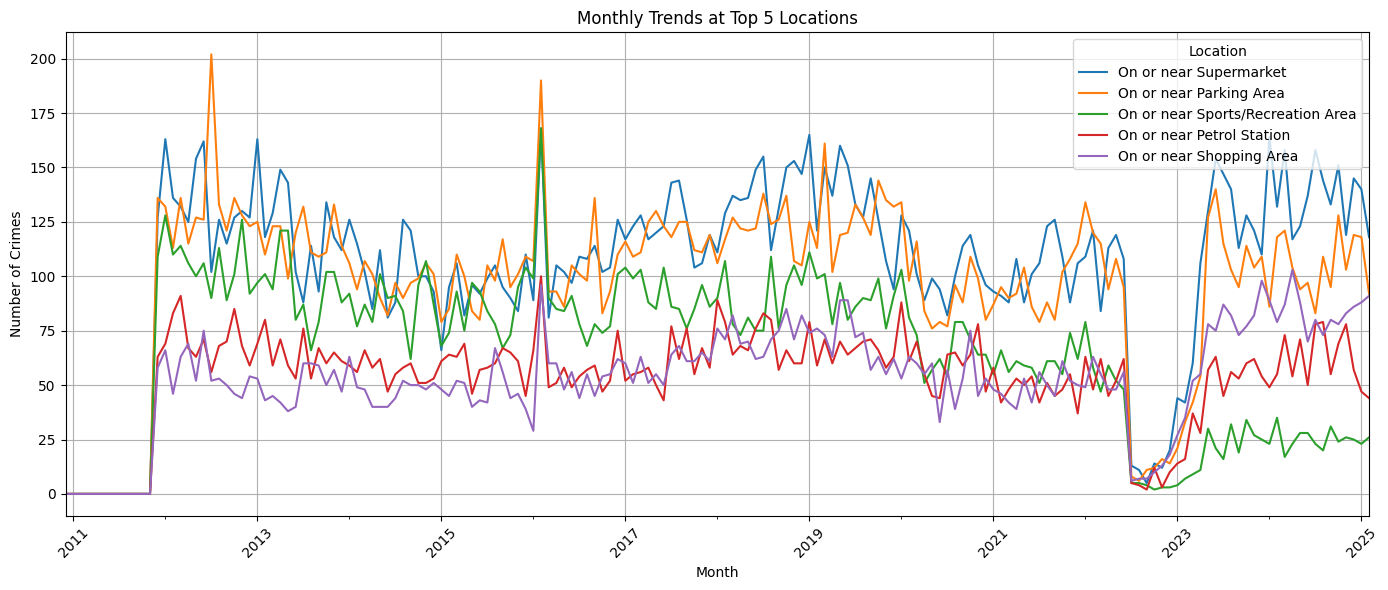

In [6]:
# Group by both Month and Location
burglary_by_location = df_burglary.groupby(['Month', 'Location']).size().reset_index(name='Crime count')

# Pivot to create a heatmap-style table
location_pivot = burglary_by_location.pivot(index='Month', columns='Location', values='Crime count').fillna(0)


top_5_locations = df_burglary['Location'].value_counts().head(5).index
location_pivot_top5 = location_pivot[top_5_locations]

# Plot trend for top 5 burglary locations
location_pivot_top5.plot(figsize=(14, 6))
plt.title('Monthly Trends at Top 5 Locations')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend(title='Location')
plt.show()


C:\Users\mariz\AppData\Local\Temp\ipykernel_19664\4225007613.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_burglary['Month_num'] = df_burglary['Month'].dt.month
C:\Users\mariz\AppData\Local\Temp\ipykernel_19664\4225007613.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_burglary['Month_name'] = df_burglary['Month'].dt.month_name()


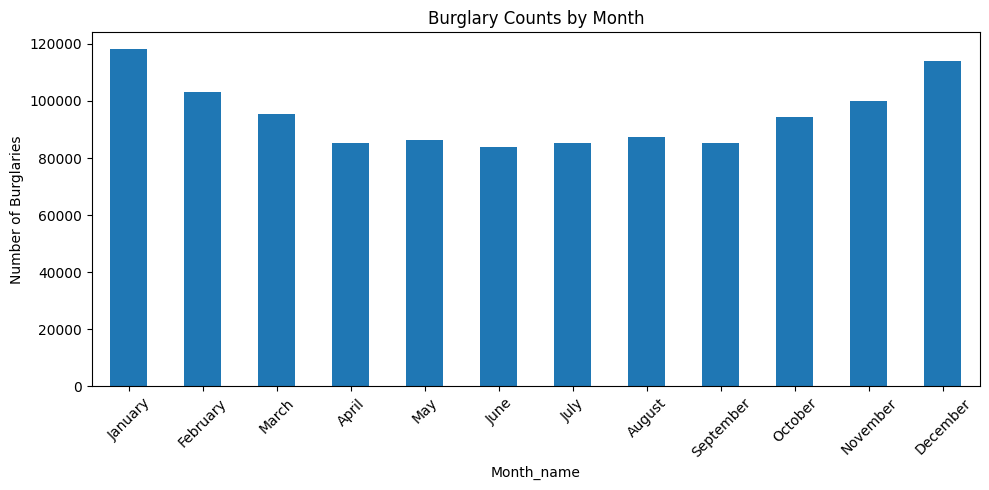

In [7]:
# Extract month and weekday from the date
df_burglary['Month_num'] = df_burglary['Month'].dt.month
df_burglary['Month_name'] = df_burglary['Month'].dt.month_name()

# Group by month
month_counts = df_burglary['Month_name'].value_counts().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
])


#Monthly seasonality
month_counts.plot(kind='bar', title='Burglary Counts by Month', figsize=(10, 5))
plt.ylabel('Number of Burglaries')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


11:05:25 - cmdstanpy - INFO - Chain [1] start processing
11:05:25 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\20231094\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
11:05:25 - cmdstanpy - INFO - Chain [1] start processing
11:05:25 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\20231094\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
11:05:26 - cmdstanpy - INFO - Chain [1] start processing
11:05:26 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\20231094\AppData\Local\Packages\PythonSoftwareFoundation.Python.


✔️ Saved per-ward forecasts to ward_level_burglary_forecasts.csv
📍 Number of wards forecasted: 625

📊 Mean of Ward-level Training Errors:
   Mean MAE: 3.27
   Mean RMSE: 4.38


C:\Users\20231094\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(
C:\Users\20231094\AppData\Local\Temp\ipykernel_2288\2170055574.py:134: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()



🌍 Global Model Evaluation on Training Data
   MAE: 703.90
   RMSE: 1152.87


C:\Users\20231094\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


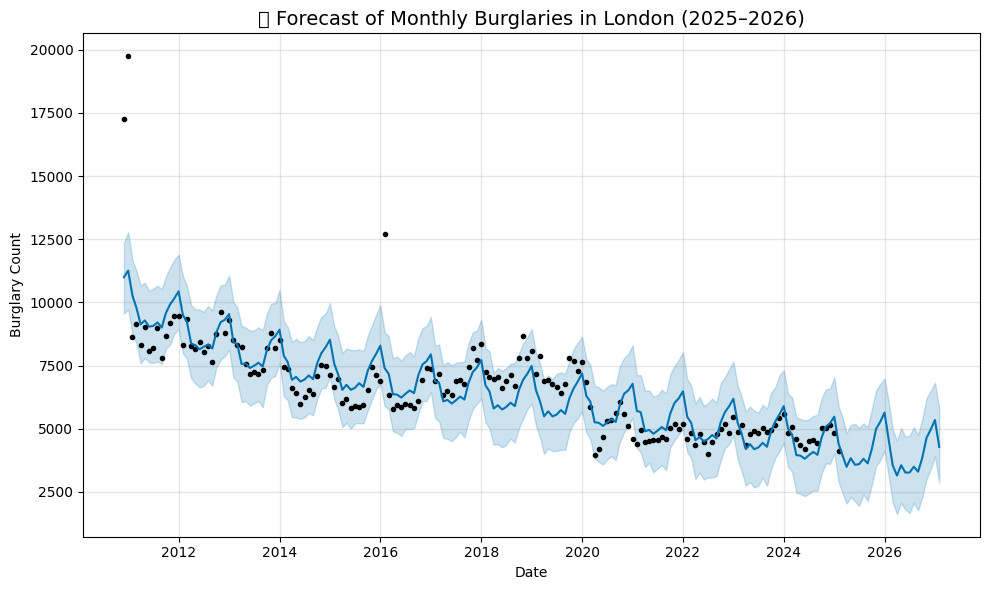

C:\Users\20231094\AppData\Local\Temp\ipykernel_2288\2170055574.py:142: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\20231094\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


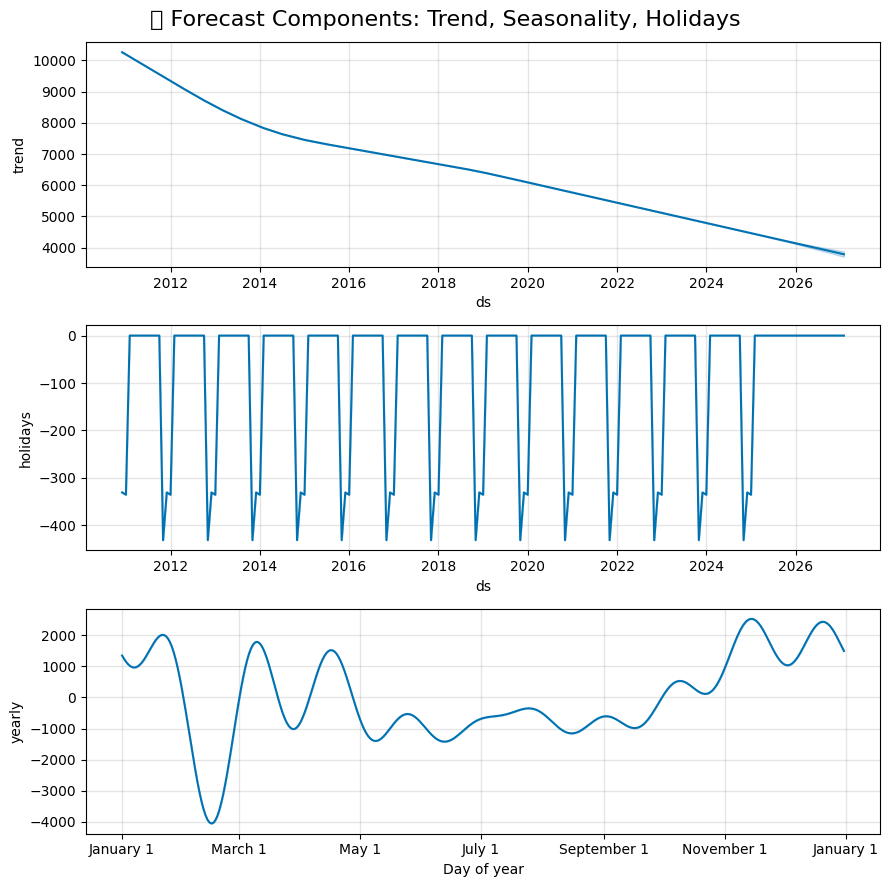


🔢 Numeric Forecasts (ds, yhat, yhat_lower, yhat_upper):
        ds         yhat  yhat_lower   yhat_upper
2010-12-01 10998.571563 9554.925109 12350.816039
2011-01-01 11256.095013 9712.783907 12780.640251
2011-02-01 10260.065107 8739.791023 11673.060938
2011-03-01  9800.414613 8388.438246 11255.653031
2011-04-01  9132.866757 7588.302078 10668.157801
2011-05-01  9287.249690 7797.047162 10782.667676
2011-06-01  9040.490707 7633.742015 10459.301486
2011-07-01  9069.098364 7601.120072 10540.665751
2011-08-01  9204.112626 7654.521155 10659.268790
2011-09-01  9006.599281 7567.901493 10510.961154
2011-10-01  9579.067387 8167.325377 11026.941800
2011-11-01  9927.343468 8331.420432 11387.614915
2011-12-01 10160.123503 8770.267091 11686.533769
2012-01-01 10437.141886 8938.114091 11885.338390
2012-02-01  9500.037122 7978.218308 11044.226060
2012-03-01  9232.120415 7766.755702 10656.179962
2012-04-01  8370.774855 6998.655361  9888.453113
2012-05-01  8308.519924 6787.735680  9727.913799
2012-06-01  

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# ==============================
# LOAD DATA
# ==============================

csv_path = 'london_crime_with_wards.csv'
df = pd.read_csv(csv_path)
df['Month'] = pd.to_datetime(df['Month'])

# Filter burglary data
df_burglary = df[(df['Crime type'] == 'Burglary') & (df['Month'] >= '2020-01-01')].copy()

# ==============================
# DEFINE HOLIDAYS (Jan, Nov, Dec)
# ==============================

holiday_months = [1, 11, 12]
month_name_map = {1: 'january', 11: 'november', 12: 'december'}
years = range(df['Month'].dt.year.min(), df['Month'].dt.year.max() + 3)
holiday_list = [{'ds': pd.Timestamp(y, m, 1), 'holiday': month_name_map[m]} for y in years for m in holiday_months]
df_holidays = pd.DataFrame(holiday_list)

# ==============================
# PART 1: FORECAST FOR EACH WARD
# ==============================

wards = df_burglary['NAME'].unique()
all_forecasts = []
mae_list = []
rmse_list = []

for ward in wards:
    ward_data = df_burglary[df_burglary['NAME'] == ward]
    df_monthly = (
        ward_data
        .groupby(ward_data['Month'].dt.to_period('M'))
        .size()
        .reset_index(name='y')
    )
    df_monthly['ds'] = df_monthly['Month'].dt.to_timestamp()
    df_monthly = df_monthly[['ds', 'y']]

    if len(df_monthly) < 24:
        continue

    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        holidays=df_holidays
    )
    model.fit(df_monthly)

    # Evaluate on training data (silently)
    forecast_train = model.predict(df_monthly[['ds']])
    mae = mean_absolute_error(df_monthly['y'], forecast_train['yhat'])
    rmse = np.sqrt(mean_squared_error(df_monthly['y'], forecast_train['yhat']))
    mae_list.append(mae)
    rmse_list.append(rmse)

    # Forecast into the future
    future = model.make_future_dataframe(periods=24, freq='M')
    forecast = model.predict(future)
    forecast['Ward'] = ward

    all_forecasts.append(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'Ward']])

# Save all ward-level forecasts
if all_forecasts:
    df_forecast_all = pd.concat(all_forecasts, ignore_index=True)
    forecast_csv = 'ward_level_burglary_forecasts.csv'
    df_forecast_all.to_csv(forecast_csv, index=False)
    print(f"\n✔️ Saved per-ward forecasts to {forecast_csv}")
    print(f"📍 Number of wards forecasted: {df_forecast_all['Ward'].nunique()}")
else:
    print("\n⚠️ No forecasts generated due to insufficient data.")

# Report average training error across wards
if mae_list and rmse_list:
    mean_mae = np.mean(mae_list)
    mean_rmse = np.mean(rmse_list)
    print(f"\n📊 Mean of Ward-level Training Errors:")
    print(f"   Mean MAE: {mean_mae:.2f}")
    print(f"   Mean RMSE: {mean_rmse:.2f}")

# ==============================
# PART 2: GLOBAL FORECAST AND PLOTS
# ==============================

# Aggregate total burglaries across London per month
df_global_monthly = (
    df_burglary
    .groupby(df_burglary['Month'].dt.to_period('M'))
    .size()
    .reset_index(name='y')
)
df_global_monthly['ds'] = df_global_monthly['Month'].dt.to_timestamp()
df_global_monthly = df_global_monthly[['ds', 'y']]

# Fit Prophet model to global data
global_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    holidays=df_holidays
)
global_model.fit(df_global_monthly)

# Evaluate on training data
forecast_train_global = global_model.predict(df_global_monthly[['ds']])
mae_global = mean_absolute_error(df_global_monthly['y'], forecast_train_global['yhat'])
rmse_global = np.sqrt(mean_squared_error(df_global_monthly['y'], forecast_train_global['yhat']))
print("\n🌍 Global Model Evaluation on Training Data")
print(f"   MAE: {mae_global:.2f}")
print(f"   RMSE: {rmse_global:.2f}")

# Create future forecast
future = global_model.make_future_dataframe(periods=24, freq='M')
forecast = global_model.predict(future)

# ==============================
# PLOT 1: Forecast Line Plot
# ==============================
fig1 = global_model.plot(forecast)
plt.title("📉 Forecast of Monthly Burglaries in London (2025–2026)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Burglary Count")
plt.tight_layout()
plt.show()

# ==============================
# PLOT 2: Forecast Components
# ==============================
fig2 = global_model.plot_components(forecast)
plt.suptitle("📊 Forecast Components: Trend, Seasonality, Holidays", fontsize=16)
plt.tight_layout()
plt.show()

# ==============================
# PLOT 3: Print Full Forecast Table
# ==============================
forecast_numeric = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
print("\n🔢 Numeric Forecasts (ds, yhat, yhat_lower, yhat_upper):")
print(forecast_numeric.to_string(index=False))

# ==============================
# PLOT 4: Monthly Average Forecasts for 2025–2026
# ==============================
forecast['year'] = forecast['ds'].dt.year
forecast['month'] = forecast['ds'].dt.month
forecast_future = forecast[forecast['year'] >= 2025]
monthly_avg = (
    forecast_future.groupby('month')['yhat']
    .mean()
    .rename(index=lambda x: pd.to_datetime(f"2025-{x}-01").strftime('%B'))
)

print("\n📌 Average monthly forecast for each month (2025–2026):")
print(monthly_avg.round(2))
